In [65]:
import numpy as np
import pandas as pd
import seaborn as sns
from time import time

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate, KFold, RepeatedStratifiedKFold
from sklearn.preprocessing import power_transform
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, ConfusionMatrixDisplay, recall_score, classification_report, f1_score
from sklearn.neighbors import KNeighborsClassifier

from sklearn.feature_selection import RFE

from tensorflow import keras
from tensorflow.keras import layers, Sequential

from keras.utils import to_categorical

from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.metrics import Precision, Recall, TruePositives, TrueNegatives, FalsePositives, FalseNegatives, AUC
from keras.utils import plot_model

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error, f1_score, r2_score,make_scorer

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import svm

import warnings

In [66]:
warnings.filterwarnings("ignore")

# Inicialização dos Dados


- Aqui, inicializamos os dados. Separamos em dois dataframes: os preditores que irão ser utilizados (as características dos vinhos) e a saída (output), ou seja, as classes da nossa classificação. Tambéma analisamos a quantidade em cada classe, para que a classificação posterior possa ser melhor explicada.

In [67]:
df = pd.read_csv('winequality-white.csv',sep= ';')

In [68]:
len(df)

4898

In [69]:
preditores = df.drop(columns = ['quality'])
saidaModel = pd.DataFrame(df['quality'], columns=['quality'])

In [70]:
display(preditores)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9
...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8


In [71]:
display(saidaModel)

,quality
0,6
1,6
2,6
3,6
4,6
...,...
4893,6
4894,5
4895,6
4896,7


In [72]:
amostras = saidaModel.values
amostras = amostras.ravel()
amostras_por_classe = np.bincount(amostras)

data_dict = {'Qualidade': list(range(len(amostras_por_classe))), 'Quantidade de Amostras': amostras_por_classe}


dataframe_amostras = pd.DataFrame(data_dict)

display(dataframe_amostras)


,Qualidade,Quantidade de Amostras
0,0,0
1,1,0
2,2,0
3,3,20
4,4,163
5,5,1457
6,6,2198
7,7,880
8,8,175
9,9,5


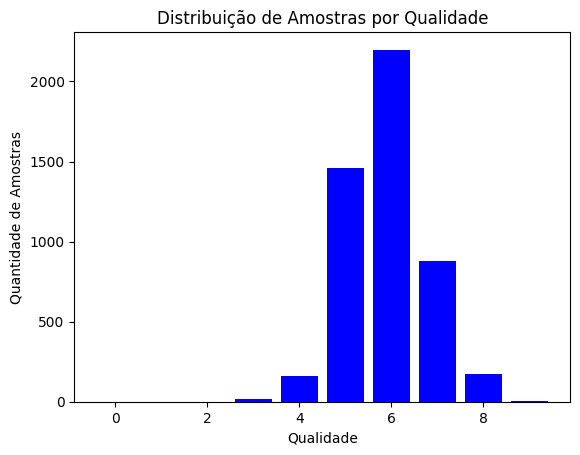

In [73]:
plt.bar(dataframe_amostras['Qualidade'], dataframe_amostras['Quantidade de Amostras'], color='blue')
plt.xlabel('Qualidade')
plt.ylabel('Quantidade de Amostras')
plt.title('Distribuição de Amostras por Qualidade')
plt.show()

#Pré-Processamento


- O pré-processamento, de início, irá se basear em "center and Scaling", ou seja, centralização e escalonamento, visto que os nossos dados possuem uma diferença muito grande de magnitude e escala. Além disso, vamos utilizar um método de log-transform como Yeo-Johnson para deixar os dados com a aparência de uma distribuição gaussiana. Os dados foram separados em dois conjuntos:

1 - Conjunto de Treinamento: O conjunto comumente utilizado para descobrir os parâmetros em métodos paramétricos. Utilizado para o treinamento do modelo, obviamente.

2 - Conjunto de Teste: Utilizado, geralmente, para a validação do modelo. Para verificar como o modelo está performando.

- Utilizamos uma separação de 75%/25%, respectivamente.

In [74]:
# "Center and Scaling"
def centralizacao(preditores):
  media = preditores.mean()
  desvio_padrao = preditores.std()
  centralizado = (preditores - media) / desvio_padrao
  return centralizado

In [75]:
preditores_pre = centralizacao(preditores)
preditores_pre = power_transform(preditores_pre, method='yeo-johnson')

In [76]:
saidaModelo = saidaModel.values

In [77]:
# Separação em treino e teste
Xtrain, Xtest, Ytrain, Ytest = train_test_split(preditores_pre, saidaModelo, test_size = 0.25, random_state = 0)

# Questão 1

- Nessa questão será avaliado os modelos de classificação lineares. Ou seja, aqueles modelos que geralmente possuem as suas fronteiras de decisão de forma linear.

- Dois métodos serão avaliados nesse momento e será escolhido o que melhor performar. Os métodos a serem avaliados são: Regressão Logística e Linear Discriminant Analisys

## Funções Auxiliares



Aqui estão algumas funções feitas pelos autores que serão utilizadas nesse trabalho para auxiliar em algum passo.


- ```show_data()``` -> Função para mostrar a acurácia e precisão do modelo.

In [78]:
def show_data(predito, yteste):
  Yt = np.copy(yteste)
  pred = np.copy(predito)
  accuracia = accuracy_score(Yt, pred)
  precisao = precision_score(Yt, pred, average='macro', zero_division=1)
  print(f"A acurácia do modelo é: {accuracia:.3}")
  print(f"A precisão do modelo é: {precisao:.3}")

## LDA (Linear Discriminant Analisys)

In [79]:
def LDA_method(Xtreino, Ytreino, Xteste, Yteste):
  Xtrain = np.copy(Xtreino)
  Ytrain = np.copy(Ytreino)
  Xtest = np.copy(Xteste)
  Ytest = np.copy(Yteste)
  Ytrain = Ytrain.ravel()
  Ytest = Ytest.ravel()


  model = LinearDiscriminantAnalysis()
  model.fit(Xtrain, Ytrain)
  Ypredict = model.predict(Xtest)

  return model, Ypredict


In [80]:
modelo_lda, predicao = LDA_method(Xtrain, Ytrain, Xtest, Ytest)
show_data(predicao,Ytest)


A acurácia do modelo é: 0.538
A precisão do modelo é: 0.603


## Matriz de Confusão

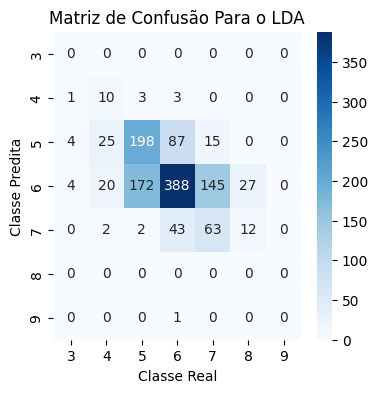

In [81]:
conf = confusion_matrix(Ytest, predicao)

classes = np.unique(np.concatenate((Ytest.ravel(), predicao)))


plt.figure(figsize=(4, 4))
sns.heatmap(conf.T, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Classe Real")
plt.ylabel("Classe Predita")
plt.title("Matriz de Confusão Para o LDA")
plt.show()

# Questão 2

## K-NN (K-ésimo Vizinho mais Próximo)

## Funções auxiliares

Aqui estão algumas funções feitas pelos autores que serão utilizadas nesse trabalho para auxiliar em algum passo.


- ```fazer_classificacao_knn(n)``` -> Função que efetivamente faz o método do knn, calcula as métricas e retorna um dicionário com essas métricas. Retornamos, a acurácia, a precisão, o recall, o f1-score e a matriz de confusão para cada n-ésimo vizinho.
- ```fazer_classificacao_knn_com_range(vizinho_minimo, vizinho_maximos)``` -> Dado que temos um conjunto de dados de treino e teste, iremos treinar nosso modelo desde uma quantidade mínima até uma quantidade máxima. Chamamos a função do_knn_classification internamente e armazenamos as informações de cada iteração numa lista.
- ```obter_maximo(lista, chave)``` -> Dado a lista da função anterior, obtemos aquela iteração que possui a melhor acurácia dado uma chave (métrica do dicionário).
- ```obter_maximo_por_estimador(lista)``` -> Dado a lista da função anterior fazer_classificacao_knn_com_range, iremos calcular qual o valor do vizinho torna cada métrica máxima.
- ```gerar_matrix_confusao_para_k_vizinhos(lista, k)``` -> Plota a matriz de confusão dado que encontramos o k que torna certa métrica máxima.
- ```testar_predicao_com_knn(k)``` -> Aplica o conjunto de teste a fim de verificar a precisão do modelo, dado que encontramos os k vizinhos.
- ```criar_grafico_com_metricas(lista)``` -> Dado a lista fornecida no fazer_classificacao_knn_com_range, iremos plotar em um gráfico como as métricas dos modelos treinados se comportam.


In [82]:
def fazer_classificacao_knn(n):
    knn = KNeighborsClassifier(n_neighbors=n)

    y_pred = cross_val_predict(knn, Xtrain, Ytrain, cv=5)

    accuracy = accuracy_score(Ytrain, y_pred)

    precision = precision_score(Ytrain, y_pred, average='weighted')
    recall = recall_score(Ytrain, y_pred, average='weighted')
    f1 = f1_score(Ytrain, y_pred, average='weighted')

    return {
        'vizinhos': n,
        'acuracia': accuracy,
    }

In [83]:
def fazer_knn_classification_com_range(vizinho_minimo, vizinho_maximos):
  lista = []
  for k in range(vizinho_minimo, vizinho_maximos + 1):
    lista.append(fazer_classificacao_knn(k))
  return lista

In [84]:
def obter_maximo(lista, chave):
  maximo = max(elem[chave] for elem in lista)
  for index, elem in enumerate(lista):
    if (maximo == elem[chave]):
      return {'vizinho': elem['vizinhos'], 'estimador': elem[chave]}

def obter_maximo_por_estimador(lista):
  maximo_acuracia = obter_maximo(lista, 'acuracia')
  return {
      'acuracia': maximo_acuracia['vizinho'],
  }

In [85]:
def gerar_matrix_confusao(predicao):
  conf = confusion_matrix(Ytest, predicao)

  classes = np.unique(np.concatenate((Ytest.ravel(), predicao)))


  plt.figure(figsize=(4, 4))
  sns.heatmap(conf.T, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
  plt.xlabel("Classe Real")
  plt.ylabel("Classe Predita")
  plt.title("Matriz de Confusão Para o k-NN")
  plt.show()

In [86]:
def testar_predicao_com_knn(k):
  modelo = KNeighborsClassifier(n_neighbors=k)
  modelo.fit(Xtrain, Ytrain)

  predicao = modelo.predict(Xtest)
  print(accuracy_score(predicao, Ytest))
  return predicao

In [87]:
def criar_grafico_com_metricas(lista):
  k_values = []
  accuracy_values = []
  precision_values = []
  recall_values = []
  f1_values = []

  for elem in lista:
      k_values.append(elem['vizinhos'])
      accuracy_values.append(elem['acuracia'])

  plt.figure(figsize=(20, 8))
  plt.plot(k_values, accuracy_values, label='Accuracy', marker='o')

  plt.title('Performance Metrics vs. Number of Neighbors (k)')
  plt.xlabel('Number of Neighbors (k)')
  plt.ylabel('Metric Value')
  plt.legend()
  plt.grid(True)
  plt.show()

## Predição do K aplicando de 1 a 70

In [88]:
vizinho_minimo = 1
vizinho_maximo = 70

In [89]:
lista1 = fazer_knn_classification_com_range(vizinho_minimo, vizinho_maximo)

In [90]:
estimadores1 =  obter_maximo_por_estimador(lista1)
estimadores1

{'acuracia': 1}

In [91]:
k_max = estimadores1['acuracia']

In [92]:
predicao = testar_predicao_com_knn(k_max)

0.6351020408163265


In [93]:
for i in range(1, 10):
  testar_predicao_com_knn(i)

0.6351020408163265
0.5820408163265306
0.5395918367346939
0.5404081632653062
0.5322448979591837
0.5314285714285715
0.5346938775510204
0.5404081632653062
0.5404081632653062


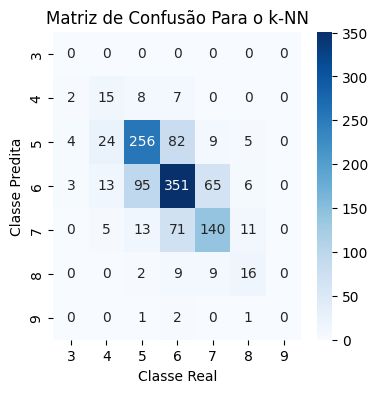

In [94]:
confusao = gerar_matrix_confusao(predicao)
confusao

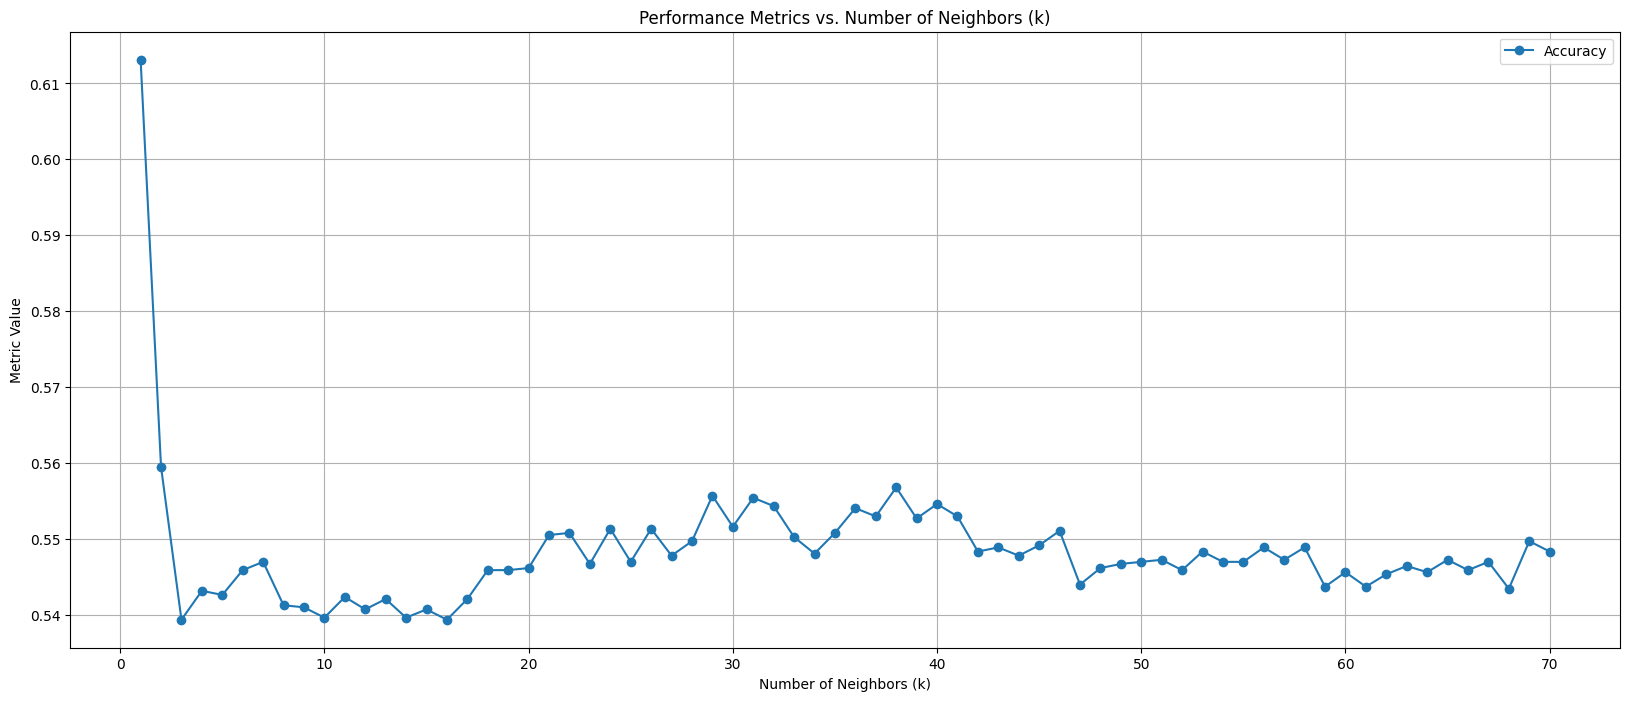

In [95]:
criar_grafico_com_metricas(lista1)

## Predição do K aplicando de 10 a 70

In [96]:
vizinho_minimo = 10
vizinho_maximo = 70

In [97]:
lista2 = fazer_knn_classification_com_range(vizinho_minimo, vizinho_maximo)

In [98]:
estimadores = obter_maximo_por_estimador(lista2)
estimadores

{'acuracia': 38}

In [99]:
k_max = estimadores['acuracia']

In [100]:
predicao = testar_predicao_com_knn(k_max)

0.5395918367346939


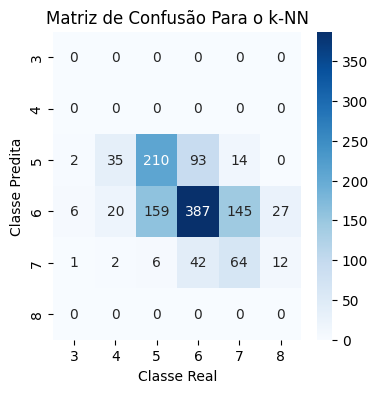

In [101]:
confusao = gerar_matrix_confusao(predicao)
confusao

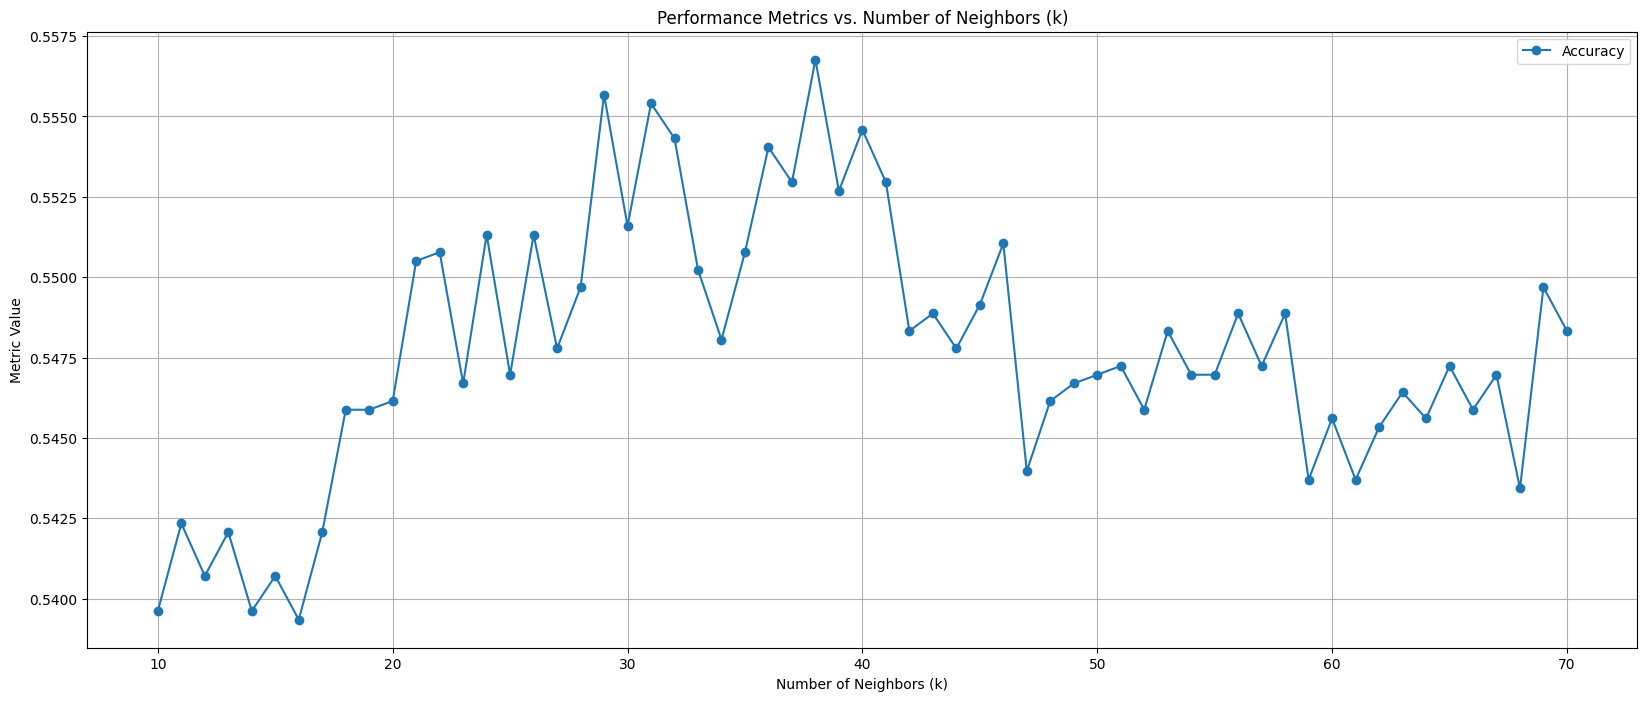

In [102]:
criar_grafico_com_metricas(lista2)

## Support Vector Machine

### Support Vector Machine sem otimização

-> Aqui não foi utilizado nenhuma otimização nos hiperparâmetros, foi apenas feito o teste com o modelo

In [103]:
model = svm.SVC(kernel='poly', C=100, degree=9, gamma='scale')

model.fit(Xtrain, Ytrain)

y_pred = model.predict(Xtest)

accuracy = metrics.accuracy_score(Ytest, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

confusionMatrix = metrics.confusion_matrix(Ytest, y_pred)
print(confusionMatrix)

Accuracy: 56.41%
[[  1   2   2   3   1   0   0]
 [  3  15  19  15   2   0   3]
 [  2  11 173 170  16   1   2]
 [  4   9  50 399  45  13   2]
 [  1   2   7 108  90  15   0]
 [  1   1   0  16   8  13   0]
 [  0   0   0   0   0   0   0]]


### Otimizando Hiper-parâmetros (Só rodar se tiver tempo)

Aqui vamos realizar a validação cruzada com diversas possibilidades de kernel, C, grau de polinômio, gamma, etc.
E o objeto best_estimator vai retornar o conjunto com a melhor acurácia média

In [104]:
#Esses códigos levam vários minutos para executar, por favor acredite nesses resultados.
# param_grid = {'C':[100], 'kernel':['poly'], 'degree':range(5,15,1)}
# grid = GridSearchCV(svm.SVC(), param_grid=param_grid, verbose=1)
# grid.fit(Xtrain, Ytrain)

In [105]:
# grid.best_estimator_

In [106]:
#Esses códigos levam vários minutos para executar, por favor acredite nesses resultados.
# param_grid = {'C':[100], 'kernel':['poly','rbf'], 'degree':[9]}
# grid = GridSearchCV(svm.SVC(), param_grid=param_grid, verbose=1)
# grid.fit(Xtrain, Ytrain)

In [107]:
#Esses códigos levam vários minutos para executar, por favor acredite nesses resultados.
# param_grid = {'C':range(1,101,1), 'kernel':['poly','rbf'], 'degree':[9]}
# grid = GridSearchCV(svm.SVC(), param_grid=param_grid, verbose=1)
# grid.fit(Xtrain, Ytrain)

In [108]:
#Esses códigos levam vários minutos para executar, por favor acredite nesses resultados.
# param_grid = {'C':range(1000,10000,100), 'kernel':['poly','rbf'], 'degree':[9]}
# grid = GridSearchCV(svm.SVC(), param_grid=param_grid, verbose=1)
# grid.fit(Xtrain, Ytrain)

In [109]:
# grid.best_estimator_

In [110]:
# param_grid = {'C':range(2600,2800,10), 'kernel':['poly','rbf'], 'degree':[9]}
# grid = GridSearchCV(svm.SVC(), param_grid=param_grid, verbose=1)
# grid.fit(Xtrain, Ytrain)

In [111]:
# grid.best_estimator_

In [112]:
# param_grid = {'C':range(2680,2690,1), 'kernel':['poly','rbf'], 'degree':[9]}
# grid = GridSearchCV(svm.SVC(), param_grid=param_grid, verbose=1)
# grid.fit(Xtrain, Ytrain)

In [113]:
# grid.best_estimator_

In [114]:
# param_grid = {'C':[2680], 'kernel':['rbf'], 'gamma':range(1,20,1)}
# grid = GridSearchCV(svm.SVC(), param_grid=param_grid, verbose=1)
# grid.fit(Xtrain, Ytrain)

In [115]:
# grid.best_estimator_

In [116]:
# param_grid = {'C':[2680], 'kernel':['rbf'], 'gamma':np.linspace(0,1,10)}
# grid = GridSearchCV(svm.SVC(), param_grid=param_grid, verbose=1)
# grid.fit(Xtrain, Ytrain)

In [117]:
# grid.best_estimator_

### SVM com parâmetros otimizados

Aqui usamos os parâmetros otimizados encontrados no resultado anterior. Para que o código não demore para rodar e verificar os resultados é recomendado pular a parte anterior, mas se deseja ver os parâmetros encontrados basta descomentar os passos anteriores.

In [118]:
model = svm.SVC(kernel='rbf', C=2680, gamma=0.7777)
model.fit(Xtrain, Ytrain)

y_pred = model.predict(Xtest)

accuracy = metrics.accuracy_score(Ytest, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 64.33%


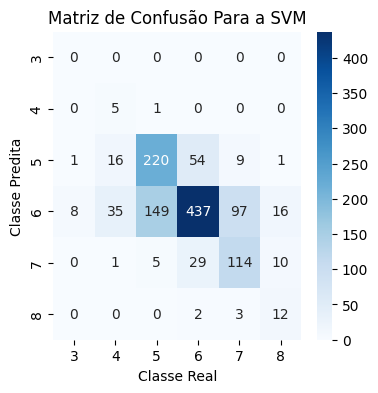

In [119]:
conf = confusion_matrix(Ytest, y_pred)

classes = np.unique(np.concatenate((Ytest.ravel(), predicao)))

plt.figure(figsize=(4, 4))
sns.heatmap(conf.T, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Classe Real")
plt.ylabel("Classe Predita")
plt.title("Matriz de Confusão Para a SVM")
plt.show()

# Questão 3 - Curva característica de operação do receptor (ROC)

Aqui realizaremos uma comparação dos métodos com o uso do ROC

## Funções auxiliares

Aqui estão algumas funções feitas pelos autores que serão utilizadas nesse trabalho para auxiliar em algum passo.


- ```calculate_tpr_fpr(y_real, y_pred)``` -> Calcula a taxa de verdadeiros positivos (True Positive Rate - TPR) e a taxa de falsos positivos (False Positive Rate - FPR) com base em rótulos reais (y_real) e rótulos previstos (y_pred). A função utiliza a matriz de confusão (confusion matrix) para realizar esses cálculos.

- ```get_n_roc_coordinates(y_real, y_proba, n = 50)``` -> Gera coordenadas para construir a curva ROC

- ```plot_roc_curve(tpr, fpr, scatter = True)``` -> Plota a curva ROC usando as informações calculadas até agora

In [120]:
def calculate_tpr_fpr(y_real, y_pred):
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    tpr =  TP/(TP + FN)
    fpr = 1 - TN/(TN+FP)

    return tpr, fpr

In [121]:
def get_n_roc_coordinates(y_real, y_proba, n = 50):
    tpr_list = [0]
    fpr_list = [0]
    for i in range(n):
        threshold = i/n
        y_pred = y_proba[:, 1] > threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list

In [122]:
import seaborn as sns
import matplotlib.pyplot as plt
def plot_roc_curve(tpr, fpr, scatter = True):
    plt.figure(figsize = (5, 5))
    if scatter:
        sns.scatterplot(x = fpr, y = tpr)
    sns.lineplot(x = fpr, y = tpr)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green')
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

In [123]:
# treina no modelo knn
modelo_knn = KNeighborsClassifier(n_neighbors=38)
modelo_knn.fit(Xtrain, Ytrain)
y_proba_knn = modelo_knn.predict_proba(Xtest)

In [124]:
# treina no modelo lda
model_lda = LinearDiscriminantAnalysis()
model_lda.fit(Xtrain, Ytrain)
y_proba_pred_lda = model_lda.predict_proba(Xtest)

In [125]:
# treina no modelo svm
modelo_svm = svm.SVC(kernel='rbf', C=2680, gamma=0.7, probability=True)
modelo_svm.fit(Xtrain, Ytrain)
y_proba_pred_svm = modelo_svm.predict_proba(Xtest)

<Figure size 800x800 with 0 Axes>

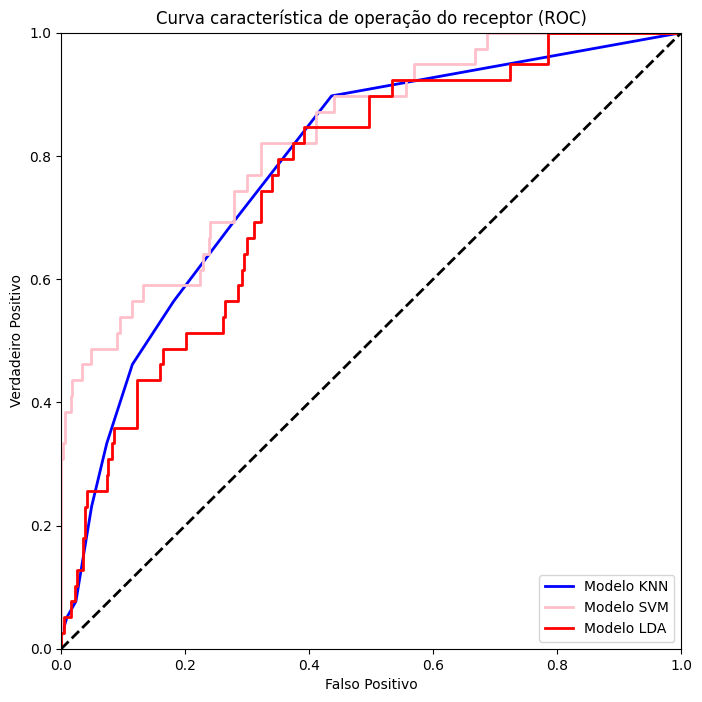

In [126]:
# plota e compara as curvas relacionados aos modelos
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

plt.figure(figsize=(8, 8))

n_classes = len(np.unique(Ytest))
y_bin = label_binarize(Ytest, classes=np.unique(Ytest))

fpr = dict()
tpr = dict()
roc_auc = dict()

x = n_classes - 1

plt.figure(figsize=(8, 8))

fpr[x], tpr[x], _ = roc_curve(y_bin[:, x], y_proba_knn[:, x])
roc_auc[x] = auc(fpr[x], tpr[x])
plt.plot(fpr[x], tpr[x], color='blue', lw=2, label=f'Modelo KNN')

fpr[x], tpr[x], _ = roc_curve(y_bin[:, x], y_proba_pred_svm[:, x])
roc_auc[x] = auc(fpr[x], tpr[x])
plt.plot(fpr[x], tpr[x], color='pink', lw=2, label=f'Modelo SVM')

fpr[x], tpr[x], _ = roc_curve(y_bin[:, x], y_proba_pred_lda[:, x])
roc_auc[x] = auc(fpr[x], tpr[x])
plt.plot(fpr[x], tpr[x], color='red', lw=2, label=f'Modelo LDA')


# Plot ROC curves
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadeiro Positivo')
plt.title('Curva característica de operação do receptor (ROC)')
plt.legend(loc='lower right')
plt.show()
